# 3 class discrimination of trialtype
. 
### Using sklean and skflow. Comparison to each of the 4 mice

In [24]:
# import tensorflow as tf
# import tensorflow.contrib.learn as skflow
import numpy as np


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns 
import random
from scipy.signal import resample
from scipy.stats import zscore
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn import cross_validation

In [26]:
# data loading function
def data_loader(mouse_name):
    theta = pd.read_csv('~/work/whiskfree/data/theta_' + mouse_name + '.csv',header=None)
    kappa = pd.read_csv('~/work/whiskfree/data/kappa_' + mouse_name + '.csv',header=None)
    tt = pd.read_csv('~/work/whiskfree/data/trialtype_' + mouse_name + '.csv',header=None)
    ch = pd.read_csv('~/work/whiskfree/data/choice_' + mouse_name + '.csv',header=None)
    sess = pd.read_csv('~/work/whiskfree/data/session_' + mouse_name + '.csv',header=None)
    AB = pd.read_csv('~/work/whiskfree/data/AB_' + mouse_name + '.csv',header=None)
    return theta, kappa, tt, ch, sess, AB

def data_parser(theta,kappa,tt,ch,sess,AB):
    
    theta_r = np.array([[resample(theta.values.squeeze()[i,950:1440],50)] for i in range(0,theta.shape[0])])
    theta_r = zscore(theta_r.squeeze(),axis=None)

    kappa_r = np.array([[resample(kappa.values.squeeze()[i,950:1440],50)] for i in range(0,kappa.shape[0])])
    kappa_r = zscore(kappa_r.squeeze(),axis=None)

    kappa_df = pd.DataFrame(kappa_r)
    theta_df = pd.DataFrame(theta_r)

    both_df = pd.concat([theta_df,kappa_df],axis=1)
    
    clean1 = np.nan_to_num(tt) !=0
    clean2 = np.nan_to_num(ch) !=0
    clean = clean1&clean2
    tt_c = tt[clean].values

    ch_c = ch[clean].values
    
    s_c = sess[clean].values
    
    ab_c = AB[clean].values

    # tt_c = tt[tt.values !=0|3].values
    both = both_df[clean]
    # both_c = both[clean.squeeze(),:]
    both_c = both.values
    
    # keeping one hot vector for now (incase we want it later)
#     labs = np.eye(3)[tt_c.astype(int)-1]
    # y[np.arange(3), a] = 1
#     labs = labs.squeeze()
    
    return both_c, tt_c, ch_c, clean, s_c, ab_c

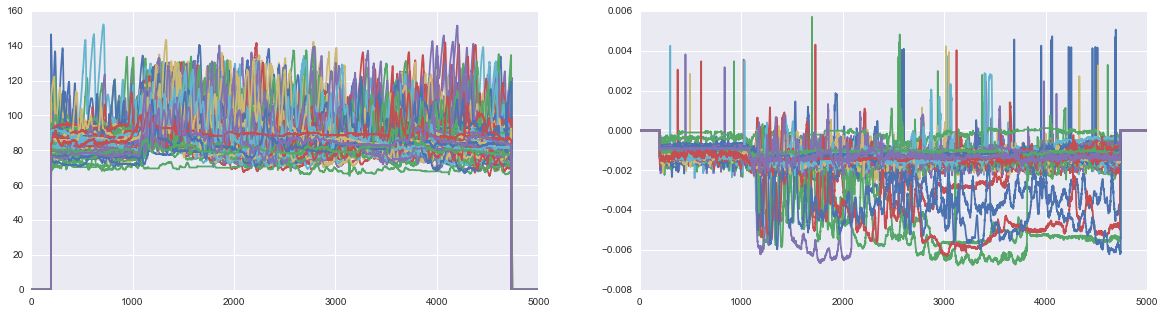

In [33]:
mouse_name = '32_r'
theta, kappa, tt, ch, sess, AB = data_loader(mouse_name)
fig, ax = plt.subplots(1,2,figsize=(20,5))
_ = ax[0].plot(theta[:100].T)
_ = ax[1].plot(kappa[:100].T)

In [34]:
AB_pol = np.nan_to_num(AB) !=0
ON_pol = np.nan_to_num(AB) ==0
cm_AB = confusion_matrix(tt[AB_pol],ch[AB_pol])
cm_ON = confusion_matrix(tt[ON_pol],ch[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt[AB_pol],ch[AB_pol]))
print(accuracy_score(tt[ON_pol],ch[ON_pol]))

[[  4  15  15   2]
 [  0 401  32  42]
 [  0  18 291  43]
 [  0  91  63 280]]
[[199  14  27]
 [ 10 196  15]
 [ 27  54 247]]
0.752505782575
0.813688212928


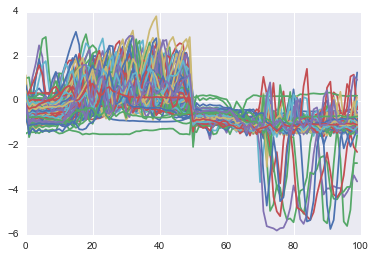

In [35]:
both_c, tt_c, ch_c, clean, s_c, ab_c = data_parser(theta,kappa,tt,ch,sess,AB)
_ = plt.plot(both_c[:100].T)

[[401  32  42]
 [ 18 291  43]
 [ 91  63 280]]
[[199  14  27]
 [ 10 196  15]
 [ 27  54 247]]
0.770816812054
0.813688212928


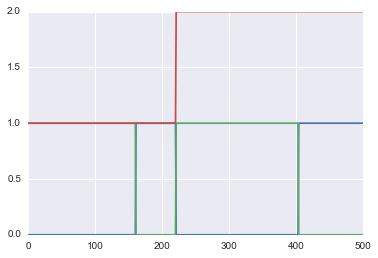

In [36]:
AB_pol = np.nan_to_num(ab_c) !=0
ON_pol = np.nan_to_num(ab_c) ==0

plt.plot(AB_pol[:500])
plt.plot(ON_pol[:500])
plt.plot(s_c[:500])

cm_AB = confusion_matrix(tt_c[AB_pol],ch_c[AB_pol])
cm_ON = confusion_matrix(tt_c[ON_pol],ch_c[ON_pol])
print(cm_AB)
print(cm_ON)
print(accuracy_score(tt_c[AB_pol],ch_c[AB_pol]))
print(accuracy_score(tt_c[ON_pol],ch_c[ON_pol]))

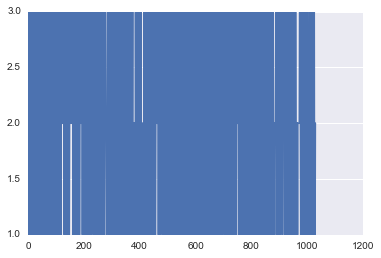

In [31]:
plt.plot(tt_c[AB_pol.squeeze()])

In [32]:
# Cross validated predictions with logistic regression for ON and rand policy
# Define models
lr = LogisticRegression()
NN = skflow.TensorFlowDNNClassifier(hidden_units=[100], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

preds_AB = cross_validation.cross_val_predict(lr, both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1, cv=5)
preds_NN_AB = cross_validation.cross_val_predict(NN, both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1, cv=5)

preds_ON = cross_validation.cross_val_predict(lr, both_c[ON_pol.squeeze()], tt_c[ON_pol.squeeze()].squeeze()-1, cv=5)
preds_NN_ON = cross_validation.cross_val_predict(NN, both_c[ON_pol.squeeze()], tt_c[ON_pol.squeeze()].squeeze()-1, cv=5)


NameError: name 'skflow' is not defined

In [ ]:
# TRIALTYPE - AB TRIALS
trialtypes = ['Anterior Pole','Posterior Pole','No Go']
# Confusion matrices. Mouse vs model
label = tt_c[AB_pol.squeeze()]
cm_m = confusion_matrix(label,ch_c[AB_pol.squeeze()])

# Confusion matrices
cm_lr = confusion_matrix(label,preds_AB+1)
cm_NN = confusion_matrix(label,preds_NN_AB+1)


with sns.axes_style("white"):
    fig,ax = plt.subplots(1,3,figsize=(15,6))


    ax[0].imshow(cm_m,interpolation='none',cmap="Greys")
    ax[0].set_title('Mouse ' + mouse_name + '. ' + str(int(100 * accuracy_score(label,ch_c[AB_pol.squeeze()]))) + '%')
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    tick_marks = np.arange(len(trialtypes))
    ax[0].set_xticks(tick_marks, trialtypes)
    ax[0].set_yticks(tick_marks, trialtypes)
    
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, cm_m[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[1].set_title('Logistic Regression' + '. ' + str(int(100 * accuracy_score(label,preds_AB+1))) + '%')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[2].imshow(cm_NN,interpolation='none',cmap="Greys")
    ax[2].set_title('Neural Network' + '. ' + str(int(100 * accuracy_score(label,preds_NN_AB+1))) + '%')
    ax[2].set_ylabel('True label')
    ax[2].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[2].text(j, i, cm_NN[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

            
plt.savefig('../figs/rand_only/Cmatrix_tt_AB_'+ mouse_name +'.png')

In [ ]:
# Try to inspect the features learnt by the LR and NN models
# b = classifier3.get_tensor_value('conv_layer1/convolution/bias:0')
NN.fit(both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1)

In [ ]:
# x = pd.DataFrame(NN.weights_)
#x = NN.weights_
#x.count?
ch

In [ ]:
# TRIALTYPE - ON TRIALS
trialtypes = ['Anterior Pole','Posterior Pole','No Go']
# Confusion matrices. Mouse vs model
label = tt_c[ON_pol.squeeze()]
cm_m = confusion_matrix(label,ch_c[ON_pol.squeeze()])

# Confusion matrices
cm_lr = confusion_matrix(label,preds_ON+1)
cm_NN = confusion_matrix(label,preds_NN_ON+1)


with sns.axes_style("white"):
    fig,ax = plt.subplots(1,3,figsize=(15,6))


    ax[0].imshow(cm_m,interpolation='none',cmap="Greys")
    ax[0].set_title('Mouse ' + mouse_name + '. ' + str(int(100 * accuracy_score(label,ch_c[ON_pol.squeeze()]))) + '%')
    ax[0].set_ylabel('True label')
    ax[0].set_xlabel('Predicted label')
    tick_marks = np.arange(len(trialtypes))
    ax[0].set_xticks(tick_marks, trialtypes)
    ax[0].set_yticks(tick_marks, trialtypes)
    
    for i in range(0,3):
        for j in range(0,3):
            ax[0].text(j, i, cm_m[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[1].imshow(cm_lr,interpolation='none',cmap="Greys")
    ax[1].set_title('Logistic Regression' + '. ' + str(int(100 * accuracy_score(label,preds_ON+1))) + '%')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[1].text(j, i, cm_lr[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

    ax[2].imshow(cm_NN,interpolation='none',cmap="Greys")
    ax[2].set_title('Neural Network' + '. ' + str(int(100 * accuracy_score(label,preds_NN_ON+1))) + '%')
    ax[2].set_ylabel('True label')
    ax[2].set_xlabel('Predicted label')
    
    for i in range(0,3):
        for j in range(0,3):
            ax[2].text(j, i, cm_NN[i,j], va='center', ha='center',bbox=dict(facecolor='white',edgecolor='white', alpha=0.5))

            
# plt.savefig('../figs/rand_only/Cmatrix_tt_ON_'+ mouse_name +'.png')

In [ ]:
! pwd

In [ ]:
# preds = cross_validation.cross_val_predict(lr, both_c, tt_c.squeeze()-1, cv=5)
# plt.hist(preds)
# x = tt_c[~np.isnan(tt_c)]
# x.shape
# plt.hist(np.nan_to_num(tt))
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1,3, figsize=(12,3))
    ax[0].hist(tt_c)
#     ax[0].hist(tt[clean.squeeze()].values) # when predicting choice
    ax[0].set_title('Trialtype')
#     ax[0].set_xticks([1,2,3],trialtypes)
    ax[0].set_xlim([0.5,3.5])
    
    ax[1].hist(ch_c)
    ax[1].set_title('Choice')
    ax[1].set_xlim([0.5,3.5])
    
    ax[2].hist(preds_NN+1)
    ax[2].set_title('NN choice')
    ax[2].set_xlim([0.5,3.5])
    

plt.suptitle('Mouse ' + mouse_name, x=0.5,y=1.1,fontsize=15)
# plt.savefig('figs/choice_number_'+ mouse_name +'.png')

In [ ]:
# LDA/PCA of data TRIALTYPE/CHOICE (change tt_c to ch_c)

from sklearn.lda import LDA
from sklearn.decomposition import PCA

trialtypes = ['Anterior Pole','Posterior Pole','No Go']

pca = PCA(n_components=20)
X_r = pca.fit(both_c[AB_pol.squeeze()]).transform(both_c[AB_pol.squeeze()]) 

lda = LDA(n_components=20)
X_r2 = lda.fit(both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()).transform(both_c[AB_pol.squeeze()])

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 0], X_r[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('PCA')

trialtypes = ['Anterior Pole','Posterior Pole','No Go']
plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r2[tt_c[AB_pol.squeeze()].squeeze() == i+1, 0], X_r2[tt_c[AB_pol.squeeze()].squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('LDA')

# plt.savefig('../figs/rand_only/LDA_PCA_tt_AB_'+ mouse_name +'.png')

In [ ]:
# Scatter with means or LDA/PCA of data TRIALTYPE/CHOICE (change tt_c to ch_c)

from sklearn.lda import LDA
from sklearn.decomposition import PCA
trialtypes = ['Anterior Pole','Posterior Pole','No Go']

pca = PCA(n_components=20)
X_r = pca.fit(both_c[AB_pol.squeeze()]).transform(both_c[AB_pol.squeeze()]) 

lda = LDA(n_components=20)
X_r2 = lda.fit(both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()).transform(both_c[AB_pol.squeeze()])

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

colours = sns.xkcd_palette(["cherry red","cornflower blue","white"])

plt.figure()
for c, i, trialtype in zip(colours, [0, 1, 2], trialtypes):
    x_data = X_r[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 0]
    y_data = X_r[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 1]
    plt.scatter(x_data, y_data, c=c, label=trialtype,alpha=0.3)
    plt.scatter(np.mean(x_data),np.mean(y_data),s=100,c=c)
plt.legend()
plt.title('PCA')

plt.savefig('../figs/rand_only/PCA_means_tt_AB_'+ mouse_name +'.png')

trialtypes = ['Anterior Pole','Posterior Pole','No Go']
plt.figure()

for c, i, trialtype in zip(colours, [0, 1, 2], trialtypes):
    x_data_2 = X_r2[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 0]
    y_data_2 = X_r2[tt_c[AB_pol.squeeze()].squeeze().ravel() == i+1, 1]
    plt.scatter(x_data_2, y_data_2, c=c, label=trialtype,alpha=0.3)
    plt.scatter(np.mean(x_data_2),np.mean(y_data_2),s=100,c=c)
    plt.legend()
plt.title('LDA')

# plt.savefig('../figs/rand_only/LDA_means_tt_AB_'+ mouse_name +'.png')

In [ ]:
# lda.score(both_c,tt_c)
x = pca.components_
fig, ax = plt.subplots(figsize=(10,5))
# _ = plt.plot(x.T,)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
# Plot histograms of LDA weight 1 for 2 pole positions
# X_r2.shape
# plt.hist?
trialtypes = ['Anterior Pole','Posterior Pole','No Go']
for i in [0,1]:
    x_data_2 = X_r2[tt_c[AB_pol.squeeze()].squeeze() == i+1, 0]
    plt.hist(x_data_2,bins=20,alpha=0.5,color=colours[i],label=trialtypes[i])

plt.legend()
    
# plt.savefig('../figs/rand_only/LDA_hist_1st_tt_AB_'+ mouse_name +'.png')

In [ ]:
c  = sns.xkcd_palette(["cherry red","cornflower blue","white"]) #("RdBu", n_colors=3)
#(ncolors=2)
sns.palplot(c)
trialtypes

In [ ]:
lda?

In [ ]:
ldas.shape

In [ ]:
# LDA/ PCA CHOICE ALL Trials
trialtypes = ['Anterior Pole','Posterior Pole','No Go']

pca = PCA(n_components=20)
X_r = pca.fit(both_c).transform(both_c)

lda = LDA(n_components=20)
X_r2 = lda.fit(both_c, ch_c).transform(both_c)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r[ch_c.squeeze() == i+1, 0], X_r[ch_c.squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('PCA')

trialtypes = ['Anterior Pole','Posterior Pole','No Go']
plt.figure()
for c, i, trialtypes in zip("rgb", [0, 1, 2], trialtypes):
    plt.scatter(X_r2[ch_c.squeeze() == i+1, 0], X_r2[ch_c.squeeze() == i+1, 1], c=c, label=trialtypes)
plt.legend()
plt.title('LDA')

# plt.savefig('../figs/rand_only/Cmatrix_ch_ALL_'+ mouse_name +'.png')

## Conv net & model weight inspection

In [ ]:
# Conv net
def max_pool_2x1(tensor_in):
    return tf.nn.max_pool(tensor_in, ksize=[1, 2, 1, 1], strides=[1, 2, 1, 1],
        padding='SAME')

def conv_model(X, y):
    # reshape X to 4d tensor with 2nd and 3rd dimensions being image width and height
    # final dimension being the number of color channels
    X = tf.reshape(X, [-1, 100, 1, 1])
    # first conv layer will compute 32 features for each 5x1 strip
    with tf.variable_scope('conv_layer1'):
        h_conv1 = skflow.ops.conv2d(X, n_filters=32, filter_shape=[5, 1], 
                                    bias=True, activation=tf.nn.relu)
        h_pool1 = max_pool_2x1(h_conv1)
    # second conv layer will compute 64 features for each 5x1 strip
    with tf.variable_scope('conv_layer2'):
        h_conv2 = skflow.ops.conv2d(h_pool1, n_filters=64, filter_shape=[5, 1], 
                                    bias=True, activation=tf.nn.relu)
        h_pool2 = max_pool_2x1(h_conv2)
        # reshape tensor into a batch of vectors
        h_pool2_flat = tf.reshape(h_pool2, [-1, 5 * 5 * 64])
    # densely connected layer with 1024 neurons
    h_fc1 = skflow.ops.dnn(h_pool2_flat, [1024], activation=tf.nn.relu, dropout=0.5)
    return skflow.models.logistic_regression(h_fc1, y)

# Training and predicting
classifier3 = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000,
    learning_rate=0.001)

In [ ]:
# Convnet
convnet = skflow.TensorFlowEstimator(
    model_fn=conv_model, n_classes=10, batch_size=100, steps=20000,
    learning_rate=0.001,verbose=0)

# convnet.fit(traindata,trainlabs1D-1)
# lr.fit(both_c,tt_c.squeeze())
# print(accuracy_score(testlabs1D-1,convnet.predict(testdata)))

scores_convnet = cross_validation.cross_val_score(convnet, both_c, tt_c.squeeze()-1, cv=5,scoring='accuracy') #'f1_weighted')

print(scores_convnet)
print(np.mean(scores_convnet))

In [ ]:
classifier3.fit(both_c[AB_pol.squeeze()], tt_c[AB_pol.squeeze()].squeeze()-1)
score_cl3 =  accuracy_score(tt_c[AB_pol.squeeze()].squeeze()-1,classifier3.predict(both_c[AB_pol.squeeze()]))

print(str(int(100 * score_cl3)) + '%')

In [ ]:
# print('1st Convolutional Layer weights and Bias')
# print(classifier3.get_tensor_value('conv_layer1/convolution/filters:0'))
b = classifier3.get_tensor_value('conv_layer1/convolution/bias:0')
b = b.squeeze()
plt.plot(np.sort(np.abs(b))[::-1])

In [ ]:
s = np.argsort(np.abs(b))[::-1]
# np.argsort?

x = classifier3.get_tensor_value('conv_layer1/convolution/filters:0')
x = x.squeeze()
_ = plt.imshow(x[:,s],interpolation='none')
# _ = plt.plot(x[:,22])

In [ ]:
# Logistic regression (once)
lr = LogisticRegression()
lr.fit(X_r2,tt_c)
# lr.fit(both_c,tt_c.squeeze())

# print(accuracy_score(testlabs1D,lr.predict(testdata)))
print(accuracy_score(ch_c.squeeze(),lr.predict(X_r2)))
lr.fit(both_c,ch_c)
print(accuracy_score(ch_c.squeeze(),lr.predict(both_c)))

In [ ]:
# Logistic regression with 5-fold cross validation
lr = LogisticRegression()
scores_lr = cross_validation.cross_val_score(lr, both_c, tt_c.squeeze(), cv=5,scoring='accuracy')

print(scores_lr)
print(np.mean(scores_lr))

In [ ]:
# 3 diff single layer NNs
# import tensorflow.contrib.learn as skflow

hidden = [3,10,50,100]

for i in range(3):
    NN = skflow.TensorFlowDNNClassifier(hidden_units=[hidden[i]], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

    scores_NN = cross_validation.cross_val_score(NN, both_c, tt_c.squeeze()-1, cv=5,scoring='f1_weighted')

    print(str(hidden[i]) + ' hidden units: ' + str(scores_NN))
    print('Mean: '+ str(np.mean(scores_NN)))

In [ ]:
print('Mean: ', np.mean(scores_NN),'blah',1)

In [ ]:
# One hidden layer neural network

NN = skflow.TensorFlowDNNClassifier(hidden_units=[100], n_classes=3,batch_size=128, steps=1000, optimizer = 'Adam',learning_rate=0.001,verbose=0)

scores_NN1 = cross_validation.cross_val_score(NN, both_c, tt_c.squeeze()-1, cv=5,scoring='f1_weighted')

print(scores_NN1)
print(np.mean(scores_NN1))

In [ ]:
# Deep net with dropout
def my_model(X, y):
    """This is DNN with 10, 20, 10 hidden layers, and dropout of 0.5 probability."""
    layers = skflow.ops.dnn(X, [10, 20, 10], dropout=0.5)
    return skflow.models.logistic_regression(layers, y)

NN_drop = skflow.TensorFlowEstimator(model_fn=my_model, n_classes=3,batch_size=128, steps=2000, optimizer = 'Adam',learning_rate=0.01,verbose=1)
scores_NN_drop = cross_validation.cross_val_score(NN_drop, both_c, tt_c.squeeze()-1, cv=5,scoring='accuracy') #'f1_weighted')

print(scores_NN_drop)
print(np.mean(scores_NN_drop))

In [ ]:
# SVM
from sklearn import svm
lin_svm = svm.LinearSVC()
scores_svm = cross_validation.cross_val_score(lin_svm,  both_c, tt_c.squeeze(),cv=5,scoring='accuracy')
print(scores_svm)
print(np.mean(scores_svm))

In [ ]:
# Naive bayes
cross_validation.cross_val_predict?

In [ ]:
# Test all 3 models with all of the data (will overfit but we'll try and fix this later...)
lr.fit(both_c,tt_c.squeeze())
NN.fit(both_c,tt_c.squeeze()-1)
# NN_drop.fit(both_c,tt_c.squeeze()-1)

In [ ]:
print('Log Reg: ',accuracy_score(tt_c.squeeze(),lr.predict(both_c)))
print('NN: ',accuracy_score(tt_c.squeeze()-1,NN.predict(both_c)))
print('Deep NN: ',accuracy_score(tt_c.squeeze()-1,NN_drop.predict(both_c)))

In [ ]:
# plt.scatter(theta,kappa)
tt1 = tt == 1
sum(tt1)
t = theta.values
t2 = t[tt1.squeeze()]
t2.shape
# tt1.shape
# fig, ax = plt.subplots(figsize=(10,5))
# _ =plt.plot(t[tt1.squeeze()])



In [ ]:
# plt.plot(tt_c[these_trials])
# plt.imshow(both_c[these_trials.squeeze()],aspect = 0.1)
# both_c.shape
# these_trials.shape
# plt.plot(NN.predict(both_c[these_trials.squeeze()]))
# plt.plot(tt_c[these_trials.squeeze()]-1)
# preds.shape
# wrong.shape
# binary_preds
# tt_c[these_trials.squeeze()]
# i?
# np.ones_like(binary_preds)
# NN.predict_proba(both_c[these_trials.squeeze()]).shape
# tt_c.shape
trialtypes = ['Left','Right','No Go']
trialtypes[1]

In [ ]:
classifier.fit(both_c,tt_c.squeeze()-1)

In [ ]:
accuracy_score(tt_c.squeeze()-1,classifier.predict(both_c))

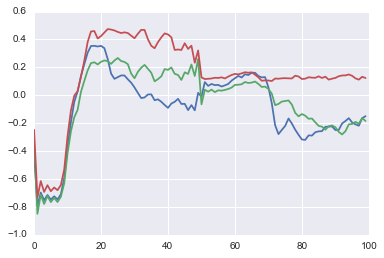

In [37]:

plt.plot(np.mean(both_c[tt_c.squeeze() ==1],0))
plt.plot(np.mean(both_c[tt_c.squeeze() ==2],0))
plt.plot(np.mean(both_c[tt_c.squeeze() ==3],0))

In [ ]:
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==1],0))
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==2],0))
plt.plot(np.mean(traindata[trainlabs1D.squeeze() ==3],0))

In [ ]:
plt.hist(preds)
wrong